In [1]:
import tensorflow as tf
import keras as keras
import pandas as pd
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt

import typing


In [2]:

def plot_multiple_histories(histories : typing.Dict, metric='loss', use_greyscale=True, show_validation=False, sort_agg_func=np.mean, sort_history_length=2, *args, **kwargs):
  """
  Plots the training history of multiple models on the same plot for comparison.
  
  Parameters:
    histories: List of History objects from multiple model's fit() calls.
    metric: The metric to plot ('loss', 'accuracy', etc.).
    labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
  """
  # Check if labels are provided, otherwise generate default labels
  # if labels is None:
  #   labels = [f'Model {i+1}' for i in range(len(histories))]
  
  # Initialize the plot
  plt.figure(figsize=(10, 6))
  
  norm = plt.Normalize(vmin=0, vmax=len(histories))
  grayscale_cmap = plt.colormaps['gray']
  
  sorted_keys = sorted(histories.keys(), key=(lambda k: sort_agg_func(histories[k].history[metric][:-sort_history_length])))
  for i, label in enumerate(sorted_keys):
    history = histories[label]
    #for i, (label, history) in enumerate(histories.items()):
    epochs = range(1, len(history.history[metric]) + 1)
    
    # Plot training metric
    plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}', color=grayscale_cmap(norm(i)))
    
    # Plot validation metric if available
    if show_validation and f'val_{metric}' in history.history:
      plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}', color=grayscale_cmap(norm(i)))
  
  # Add labels and title
  plt.title(f'Comparison of {metric.capitalize()} Between Models')
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.legend()
  
  # Show plot
  plt.show()


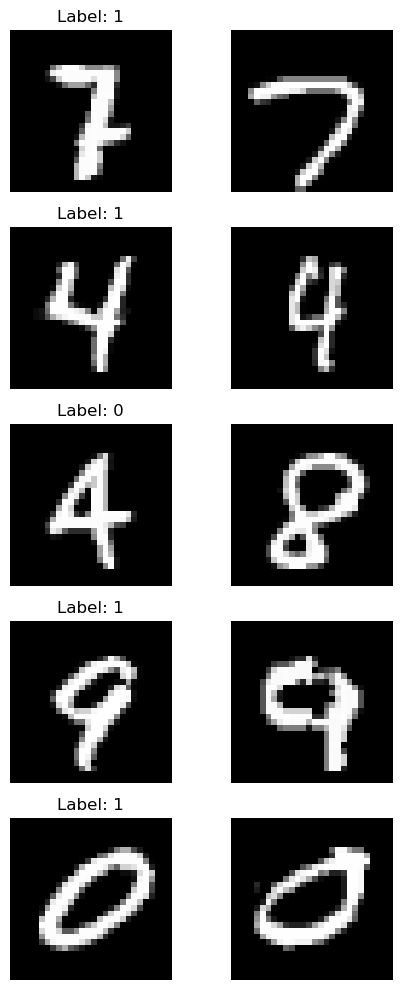

In [3]:


# Load MNIST dataset
def load_mnist_data():
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
  x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0
  return (x_train, y_train), (x_test, y_test)

# Create pairs of images with labels (1 for same, 0 for different)
def create_pairs(x, y):
  pairs = []
  labels = []
  num_classes = len(np.unique(y))
  digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
  
  for idx1 in range(len(x)):
    # Add a positive pair (same digit)
    x1 = x[idx1]
    label = y[idx1]
    idx2 = np.random.choice(digit_indices[label])
    x2 = x[idx2]
    
    pairs.append([x1, x2])
    labels.append(1)
    
    # Add a negative pair (different digit)
    neg_label = np.random.choice(list(set(range(num_classes)) - {label}))
    idx2 = np.random.choice(digit_indices[neg_label])
    x2 = x[idx2]
    
    pairs.append([x1, x2])
    labels.append(0)
  
  # Shuffle the pairs and labels
  pairs = np.array(pairs)
  labels = np.array(labels)
  shuffle_indices = np.random.permutation(len(pairs))
  return pairs[shuffle_indices], labels[shuffle_indices]

# Prepare the data for training
(x_train, y_train), (x_test, y_test) = load_mnist_data()

train_pairs, train_labels = create_pairs(x_train, y_train)
test_pairs, test_labels = create_pairs(x_test, y_test)

# Split into training and validation sets
(train_pairs, val_pairs, train_labels, val_labels) = sklearn.model_selection.train_test_split(
  train_pairs, train_labels, test_size=0.1, random_state=42
)

# Unpack pairs for training
def unpack_pairs(pairs):
  return [pairs[:, 0], pairs[:, 1]]

train_pairs_unpacked = unpack_pairs(train_pairs)
val_pairs_unpacked = unpack_pairs(val_pairs)
test_pairs_unpacked = unpack_pairs(test_pairs)

# Sanity check: Visualize a few image pairs and their labels
def plot_pairs(pairs, labels, n=5):
  fig, axes = plt.subplots(n, 2, figsize=(5, n*2))
  for i in range(n):
    axes[i, 0].imshow(pairs[0][i].reshape(28, 28), cmap='gray')
    axes[i, 1].imshow(pairs[1][i].reshape(28, 28), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 0].set_title(f'Label: {labels[i]}')
  plt.tight_layout()
  plt.show()

# Plot 5 random training pairs
plot_pairs(train_pairs_unpacked, train_labels, n=5)


In [9]:

input_shape = (28, 28, 1)  # Adding the channel dimension for MNIST
embedding_size = 100

def get_embedded_model(inputs) -> keras.models.Model:
  x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
  #
  # CNN Model code here
  #
  encoded = keras.layers.Dense(embedding_size, activation="tanh")(x)  # Changed to tanh
  embedding_model = keras.Model(inputs, encoded)
  return embedding_model

# Define the Euclidean distance function using tf.math
def euclidean_distance(vectors):
  (x0, x1) = vectors
  sum_squared = tf.math.reduce_sum(tf.math.square(x0 - x1), axis=1, keepdims=True)
  return tf.math.sqrt(sum_squared)

# Create the two inputs
input0 = keras.layers.Input(input_shape, name='input0')
input1 = keras.layers.Input(input_shape, name='input1')

# Create the embedding models
embedding_model = get_embedded_model(keras.layers.Input(input_shape))  # Shared model
sub0 = embedding_model(input0)  # Get the embeddings from the model
sub1 = embedding_model(input1)

# Compute the Euclidean distance between the embeddings
merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([sub0, sub1])

# Create the Siamese model
model = keras.Model([input0, input1], merge_layer)

# Compile the model using contrastive loss
def contrastive_loss(margin=1.0):
  def loss(y_true, y_pred):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
  return loss

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
  loss=contrastive_loss(margin=1.0),
  metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input0 (InputLayer) │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input1 (InputLayer) │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 100)       │    105,572 │ input0[0][0],     │
│ (Functional)        │                   │            │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_4[0][… │
│                     │                   │            │ functional_4[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,572 (412.39 KB)

 Trainable params: 105,572 (412.39 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Train the model
history = model.fit(
  [train_pairs_unpacked[0], train_pairs_unpacked[1]], train_labels,
  validation_data=([val_pairs_unpacked[0], val_pairs_unpacked[1]], val_labels),
  batch_size=512,
  epochs=100
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(
  [test_pairs_unpacked[0], test_pairs_unpacked[1]], test_labels
)


Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3553 - loss: 0.2199 - val_accuracy: 0.1875 - val_loss: 0.1410
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1606 - loss: 0.1479 - val_accuracy: 0.1156 - val_loss: 0.1027
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1189 - loss: 0.1228 - val_accuracy: 0.0972 - val_loss: 0.0884
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1017 - loss: 0.1090 - val_accuracy: 0.0840 - val_loss: 0.0786
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0896 - loss: 0.0991 - val_accuracy: 0.0758 - val_loss: 0.0730
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0790 - loss: 0.0917 - val_accuracy: 0.0637 - val_loss: 0.0666
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0716 - loss: 0.0858 - val_accuracy: 0.0553 - val_loss: 0.0619
Epoch 8/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.0634 - loss: 0.0803 - 

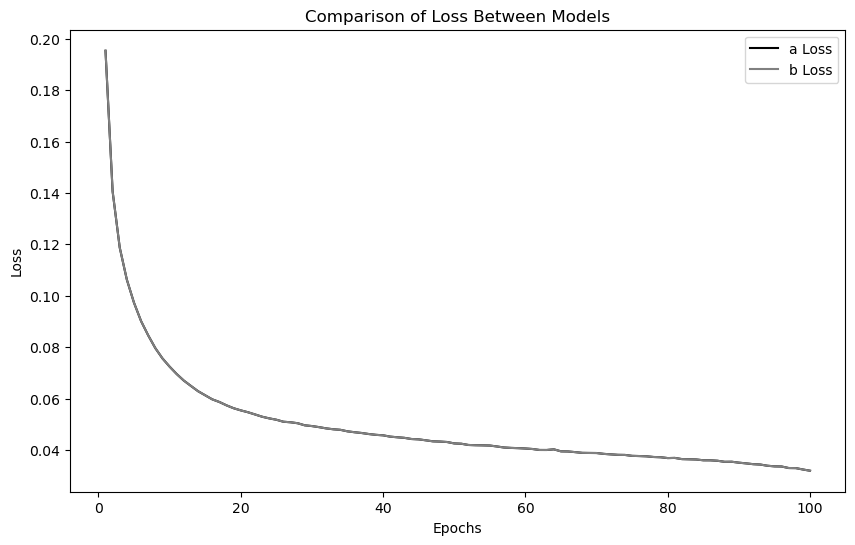

In [11]:
plot_multiple_histories({'a': history, 'b':history})